# Simultaneous plume analysis — EMIT & GHGSat (Pakistan, 2024-02-28)

This notebook stitches together the plume analysis workflows for a single EMIT L2B product and a single GHGSat product acquired over Pakistan on 2024-02-28. It mirrors the Buenos Aires multi-sensor notebook but only includes EMIT and GHGSat, producing recap tables and quick-look mosaics.


## 1. Setup
Import the shared geospatial utilities, add the repository root to `sys.path`, and configure a common output folder for any intermediate clips generated during the walkthrough.


In [16]:

import os
import sys
import math
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from osgeo import gdal, ogr
from pyproj import CRS
import geopandas as gpd
import matplotlib.pyplot as plt

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts import plumes_analyzer

plt.rcParams['figure.dpi'] = 110
OUTPUT_BASE = NOTEBOOK_ROOT / 'outputs' / 'Pakistan_dual_sat_case'
OUTPUT_BASE.mkdir(parents=True, exist_ok=True)


## 2. Configure the simultaneous acquisitions
Paths point to the two collocated scenes (EMIT and GHGSat) captured on 2024-02-28 over Pakistan. Wind assumptions are aligned across both satellites for comparability.


In [17]:

BASE_DIR = Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas')
PK_ROOT = BASE_DIR / 'case_studies_data' / 'Pakistan_20240228'

VECTOR_IME_ONLY = Path("/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/ime_com_aoi_exp/ime_com_area.shp")

VECTOR_PATH_EMIT = Path("/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/flux_exp/emit_seg/EMIT_L2B_CH4ENH_002_20240228T043521_2405903_003_plumes_scaled.geojson")
VECTOR_PATH_GHG = Path("/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/flux_exp/ghg_seg/C2_25044054_20240228_20250103_9iY6jsy_CH4_plumes_scaled.geojson")
#VECTOR_PATH_EMIT = VECTOR_IME_ONLY
#VECTOR_PATH_GHG = VECTOR_IME_ONLY



COMMON_WIND = {'u10': 2.7, 'sigma_u10': 1.0}

EMIT_ROOT = PK_ROOT / 'emit' / 'full_dataset' / 'EMITL2BCH4ENH_002-20251117_160414'
EMIT_CASE = {
    'label': 'emit_pakistan',
    'scene': 'Pakistan (EMIT)',
    'sensor_type': 'EMIT',
    'unit': 'ppm-m',
    'concentration_file': EMIT_ROOT / 'EMIT_L2B_CH4ENH_002_20240228T043521_2405903_003.tif',
    'uncertainty_file': EMIT_ROOT / 'EMIT_L2B_CH4UNCERT_002_20240228T043521_2405903_003.tif',
    'vector_path': VECTOR_PATH_EMIT,
    'wind': COMMON_WIND,
    'gsd': 60,
}

GHGSAT_ROOT = PK_ROOT / 'C2_25044054_20240228_20250103_9iY6jsy'
GHGSAT_CASE = {
    'label': 'ghgsat_pakistan',
    'scene': 'Pakistan (GHGSat)',
    'sensor_type': 'GHGSAT',
    'unit': 'ppb',
    'concentration_file': GHGSAT_ROOT / 'C2_25044054_20240228_20250103_9iY6jsy_CH4.tif',
    'uncertainty_file': GHGSAT_ROOT / 'C2_25044054_20240228_20250103_9iY6jsy_CH4ER.tif',
    'vector_path': VECTOR_PATH_GHG,
    'wind': COMMON_WIND,
    'gsd': None,
}

GHGSAT_U_EFF_LOG_COEFF = 0.90
GHGSAT_U_EFF_OFFSET = 0.60

print('Configured EMIT and GHGSat cases for Pakistan.')


Configured EMIT and GHGSat cases for Pakistan.


## 3. Lightweight reporting helper
`RunReporter` mirrors the per-satellite notebooks: it collects text blocks and figures and can optionally emit a Markdown run log alongside the notebook outputs.


In [18]:
SAVE_RUN_REPORT = True
REPORT_FILE = OUTPUT_BASE / 'plume_analysis_run_report.md'
REPORT_ASSETS_DIR = OUTPUT_BASE / 'assets'

class RunReporter:
    def __init__(self, enabled, report_path, assets_dir, title='Plume Analysis Run Report'):
        self.enabled = bool(enabled)
        self.report_path = Path(report_path) if report_path else None
        self.assets_dir = Path(assets_dir) if assets_dir else None
        self.title = title
        self.sections = []
        if self.enabled and self.assets_dir:
            self.assets_dir.mkdir(parents=True, exist_ok=True)
            self._start_report()

    def _start_report(self):
        if not self.report_path:
            return
        header = f"# {self.title}\n\nGenerated: {datetime.utcnow().isoformat()}Z\n\n"
        self.report_path.write_text(header)

    def log_block(self, title, lines):
        if not self.enabled:
            return
        block = f"\n## {title}\n" + "\n".join(f"- {ln}" for ln in lines) + "\n"
        self.sections.append(block)
        if self.report_path:
            with open(self.report_path, 'a') as f:
                f.write(block)

    def log_figure(self, title, fig):
        if not (self.enabled and self.assets_dir):
            return
        safe = ''.join(ch.lower() if ch.isalnum() else '_' for ch in title).strip('_')
        asset_path = self.assets_dir / f"{safe}.png"
        fig.savefig(asset_path, dpi=150, bbox_inches='tight')
        self.log_block(title, [f"Figure: {asset_path.name}"])

    def save(self):
        if self.enabled and self.report_path:
            print(f"Report saved to {self.report_path}")

reporter = RunReporter(SAVE_RUN_REPORT, REPORT_FILE, REPORT_ASSETS_DIR, title='Pakistan EMIT + GHGSat plume analysis')

## 4. Helper functions
Utilities to rasterize plume masks, process each plume polygon, and assemble mosaics and recap tables.


In [19]:


def _rasterize_vector(vector_path, rows, cols, geo_transform, projection):
    vector_ds = ogr.Open(str(vector_path))
    if vector_ds is None:
        raise RuntimeError(f'Failed to open vector file: {vector_path}')
    layer = vector_ds.GetLayer()
    mask_ds = gdal.GetDriverByName('MEM').Create('', cols, rows, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(geo_transform)
    mask_ds.SetProjection(projection)
    gdal.RasterizeLayer(mask_ds, [1], layer, burn_values=[1])
    mask_array = mask_ds.ReadAsArray().astype(bool)
    mask_ds = None
    layer = None
    vector_ds = None
    return mask_array


def compute_ghgsat_u_eff(u10):
    if u10 <= 0:
        raise ValueError('U10 must be positive for the GHGSat logarithmic U_eff relationship.')
    return GHGSAT_U_EFF_LOG_COEFF * math.log(u10) + GHGSAT_U_EFF_OFFSET


def compute_ghgsat_u_eff_derivative(u10):
    if u10 <= 0:
        raise ValueError('U10 must be positive for the GHGSat logarithmic U_eff derivative.')
    return GHGSAT_U_EFF_LOG_COEFF / u10


def load_case_arrays(concentration_file, uncertainty_file):
    conc_arr, geotransform, projection, _ = plumes_analyzer.load_geotiff(str(concentration_file))
    unc_arr, _, _, _ = plumes_analyzer.load_geotiff(str(uncertainty_file))
    return conc_arr, unc_arr, geotransform, projection


def convert_units(conc_arr, unc_arr, unit):
    conc_clean = plumes_analyzer.discard_neg(conc_arr)
    unc_clean = plumes_analyzer.discard_neg(unc_arr)
    if unit == 'ppm-m':
        return plumes_analyzer.ppm_m_to_ppb(conc_clean), plumes_analyzer.ppm_m_to_ppb(unc_clean)
    return conc_clean, unc_clean


def analyze_case(case_cfg, reporter, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    conc_raw, unc_raw, gt, proj = load_case_arrays(case_cfg['concentration_file'], case_cfg['uncertainty_file'])
    conc_ppb, unc_ppb = convert_units(conc_raw, unc_raw, case_cfg['unit'])
    gsd = case_cfg.get('gsd') or abs(gt[1])
    sigma_surf_ppb = 0.0

    gdf = gpd.read_file(case_cfg['vector_path'])
    _, _, raster_wkt, _ = plumes_analyzer.load_geotiff(str(case_cfg['concentration_file']))
    raster_crs = CRS.from_wkt(raster_wkt)
    gdf_raster = gdf.to_crs(raster_crs)
    projected_gdf, projected_epsg = plumes_analyzer.project_gdf_to_local_utm(gdf)

    plumes = []
    for idx, (row_raster, row_proj) in enumerate(zip(gdf_raster.itertuples(), projected_gdf.itertuples()), start=1):
        poly = row_raster.geometry
        clip_conc_path = output_dir / f"{case_cfg['label']}_plume{idx}_conc.tif"
        clip_unc_path = output_dir / f"{case_cfg['label']}_plume{idx}_unc.tif"
        clipped_conc = plumes_analyzer.clip_raster_to_polygon(str(case_cfg['concentration_file']), poly, str(clip_conc_path))
        clipped_unc = plumes_analyzer.clip_raster_to_polygon(str(case_cfg['uncertainty_file']), poly, str(clip_unc_path))
        clipped_conc_ppb, clipped_unc_ppb = convert_units(clipped_conc, clipped_unc, case_cfg['unit'])
        clipped_unc_total_ppb = np.sqrt(np.square(clipped_unc_ppb) + sigma_surf_ppb ** 2)
        stats = plumes_analyzer.compute_plume_stats(clipped_conc_ppb)

        area_m2 = row_proj.geometry.area
        pixel_count = int(round(area_m2 / (gsd ** 2)))
        L = math.sqrt(area_m2)
        wind = case_cfg['wind']
        if case_cfg['sensor_type'] == 'GHGSAT':
            u_eff = compute_ghgsat_u_eff(wind['u10'])
            a_coeff = compute_ghgsat_u_eff_derivative(wind['u10'])
        else:
            u_eff, a_coeff, _ = plumes_analyzer.compute_u_eff(wind['u10'], case_cfg['sensor_type'])
        ime = plumes_analyzer.calculate_ime(clipped_conc_ppb, gsd)
        sigma_ime = plumes_analyzer.calculate_sigma_ime(clipped_unc_total_ppb, gsd)
        sigma_ime_instr = plumes_analyzer.calculate_sigma_ime(clipped_unc_ppb, gsd)
        q = plumes_analyzer.compute_flux(ime, u_eff, L)
        sigma_q, sigma_q_ime, sigma_q_wind = plumes_analyzer.propagate_flux_uncertainty(
            q, ime, sigma_ime, wind['u10'], wind['sigma_u10'], u_eff, a_coeff
        )

        plumes.append(
            {
                'plume_id': idx,
                'area_m2': area_m2,
                'pixel_count': pixel_count,
                'L': L,
                'u_eff': u_eff,
                'ime': ime,
                'sigma_ime': sigma_ime,
                'sigma_ime_instr': sigma_ime_instr,
                'q': q,
                'sigma_q': sigma_q,
                'sigma_q_ime': sigma_q_ime,
                'sigma_q_wind': sigma_q_wind,
                'stats': stats,
                'clipped_conc_ppb': clipped_conc_ppb,
                'clipped_unc_ppb': clipped_unc_ppb,
                'clipped_unc_total_ppb': clipped_unc_total_ppb,
            },
        )

        reporter.log_block(
            f"{case_cfg['label']} plume {idx}",
            [
                f"Area: {area_m2:.2f} m^2 (approx {pixel_count} pixels @ {gsd} m)",
                f"IME: {ime:.2f} ± {sigma_ime:.2f} kg",
                f"Flux: {q:.2f} ± {sigma_q:.2f} t/h",
            ],
        )

    return {
        'label': case_cfg['label'],
        'scene': case_cfg['scene'],
        'sensor': case_cfg['sensor_type'],
        'unit': case_cfg['unit'],
        'gsd': gsd,
        'wind': case_cfg['wind'],
        'sigma_surf_ppb': sigma_surf_ppb,
        'plumes': plumes,
        'concentration_raw': conc_raw,
        'concentration_ppb': conc_ppb,
        'uncertainty_raw': unc_raw,
        'uncertainty_ppb': unc_ppb,
        'geotransform': gt,
        'projection': proj,
        'vector_path': case_cfg['vector_path'],
    }


def build_recap_table(results):
    rows = []
    for res in results:
        for plume in res['plumes']:
            rows.append(
                {
                    'sensor': res['sensor'],
                    'case': res['label'],
                    'plume_id': plume['plume_id'],
                    'pixels': plume['pixel_count'],
                    'area_m2': plume['area_m2'],
                    'IME_kg': plume['ime'],
                    'sigma_IME_kg': plume['sigma_ime'],
                    'Flux_tph': plume['q'],
                    'sigma_Flux_tph': plume['sigma_q'],
                },
            )
    df = pd.DataFrame(rows)
    if not df.empty:
        ordered_cols = ['sensor', 'case', 'plume_id', 'pixels', 'area_m2', 'IME_kg', 'sigma_IME_kg', 'Flux_tph', 'sigma_Flux_tph']
        df = df[ordered_cols]
    return df


def mosaic_plot(results, key, title, cmap='plasma', vmin=0, vmax=None, cols=2):
    n = len(results)
    cols = min(cols, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows))
    axes = np.atleast_2d(axes)
    flat_axes = axes.flat

    fig.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.06, wspace=0.08, hspace=0.08)

    vmax = vmax if vmax is not None else max(float(np.nanmax(res[key])) for res in results)
    for ax, res in zip(flat_axes, results):
        arr = res[key]
        im = ax.imshow(np.ma.masked_invalid(arr), cmap=cmap, vmin=vmin, vmax=vmax)
        label = res['label']
        ax.set_title(label, fontsize=9)
        ax.axis('off')

    for ax in list(flat_axes)[n:]:
        ax.axis('off')

    cax = fig.add_axes([0.83, 0.15, 0.025, 0.65])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(title)

    fig.suptitle(title, fontsize=14)
    return fig

## 5. Run the analyses
Loop through the EMIT and GHGSat scenes, compute IME/flux with uncertainties, and keep the full-scene arrays for mosaics.


In [20]:

all_results = []

for cfg in [EMIT_CASE, GHGSAT_CASE]:
    case_dir = OUTPUT_BASE / cfg['label']
    res = analyze_case(cfg, reporter, case_dir)
    all_results.append(res)
    print(f"Processed {cfg['label']}: {len(res['plumes'])} plume(s)")

reporter.save()


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:6123: RuntimeWarning: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


Processed emit_pakistan: 1 plume(s)
Processed ghgsat_pakistan: 1 plume(s)
Report saved to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/Pakistan_dual_sat_case/plume_analysis_run_report.md


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:6123: RuntimeWarning: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


## 6. Recap table
Areas (pixels and m²), IME with uncertainties, and fluxes with propagated uncertainty for every plume across both sensors.


In [21]:

recap_df = build_recap_table(all_results)
recap_df.style.format({
    'area_m2': '{:,.0f}',
    'IME_kg': '{:.2f}',
    'sigma_IME_kg': '{:.2f}',
    'Flux_tph': '{:.2f}',
    'sigma_Flux_tph': '{:.2f}',
}).hide(axis='index')


sensor,case,plume_id,pixels,area_m2,IME_kg,sigma_IME_kg,Flux_tph,sigma_Flux_tph
EMIT,emit_pakistan,1,1241,"4,466,168",3524.23,94.23,11.32,2.72
GHGSAT,ghgsat_pakistan,1,4783,"4,215,861",4804.24,15.61,12.58,2.81


## 7. Mosaics
Quick-look mosaics of concentration and uncertainty maps for both sensors.


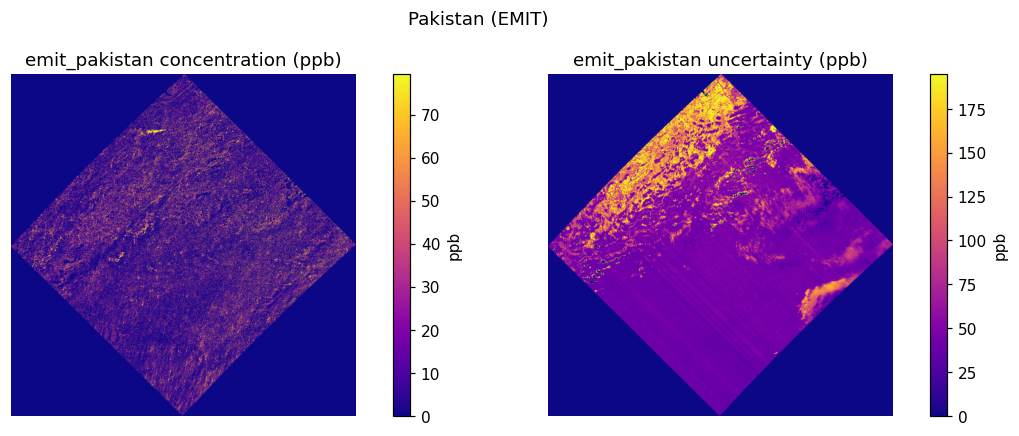

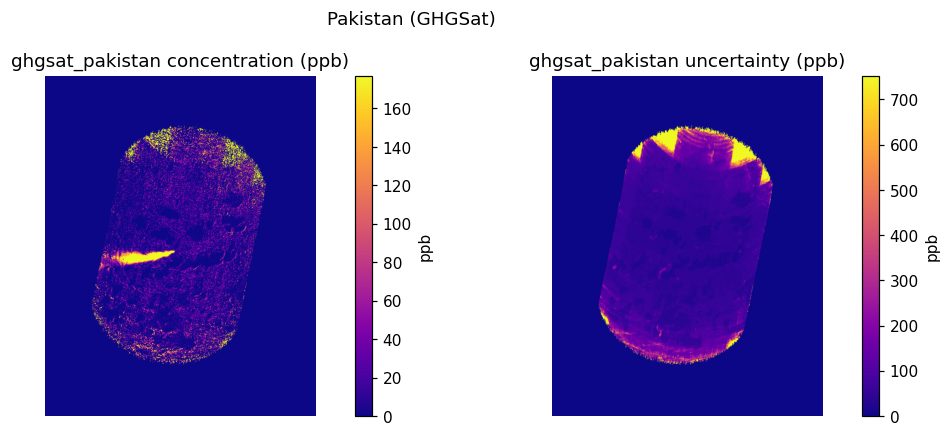

In [22]:
for res in all_results:
    conc = res.get('concentration_ppb', res['concentration_raw'])
    unc = res.get('uncertainty_ppb', res['uncertainty_raw'])
    conc_vmax = float(np.nanpercentile(conc, 99)) if conc.size else None
    if not np.isfinite(conc_vmax) or conc_vmax <= 0:
        conc_vmax = float(np.nanmax(conc)) if np.isfinite(np.nanmax(conc)) else None
    unc_vmax = float(np.nanpercentile(unc, 99)) if unc.size else None
    if not np.isfinite(unc_vmax) or unc_vmax <= 0:
        unc_vmax = float(np.nanmax(unc)) if np.isfinite(np.nanmax(unc)) else None
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axes[0].imshow(conc, cmap='plasma', vmin=0, vmax=conc_vmax)
    axes[0].set_title(f"{res['label']} concentration (ppb)")
    cbar0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.08)
    cbar0.set_label('ppb')
    im1 = axes[1].imshow(unc, cmap='plasma', vmin=0, vmax=unc_vmax)
    axes[1].set_title(f"{res['label']} uncertainty (ppb)")
    cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.08)
    cbar1.set_label('ppb')
    for ax in axes:
        ax.axis('off')
    fig.suptitle(res['scene'], fontsize=12)
    reporter.log_figure(f"{res['label']}_quicklook", fig)
    plt.tight_layout()
    plt.show()


## 8. Segmented plume overlays
Zoomed concentration/uncertainty maps over the segmented plume polygons, with the plume mask outlined.

In [23]:
def _crop_with_padding(mask, pad=6):
    rows, cols = np.where(mask)
    if rows.size == 0:
        return None
    r0 = max(int(rows.min()) - pad, 0)
    r1 = min(int(rows.max()) + pad + 1, mask.shape[0])
    c0 = max(int(cols.min()) - pad, 0)
    c1 = min(int(cols.max()) + pad + 1, mask.shape[1])
    return r0, r1, c0, c1


def _auto_vmax(arr, pct=99.0):
    if arr.size == 0:
        return None
    vmax = float(np.nanpercentile(arr, pct))
    if not np.isfinite(vmax) or vmax <= 0:
        vmax = float(np.nanmax(arr)) if np.isfinite(np.nanmax(arr)) else None
    return vmax if vmax and vmax > 0 else None


def plot_segmented_overlays(results, reporter=None, vmin_conc=0, vmin_unc=0, padding=6, pct=99.0):
    for res in results:
        vector_path = res.get('vector_path')
        mask = res.get('plume_mask')
        conc_map = res.get('concentration_ppb', res.get('concentration_raw'))
        unc_map = res.get('uncertainty_ppb', res.get('uncertainty_raw'))
        if conc_map is None or unc_map is None:
            continue
        if mask is None and vector_path is not None:
            mask = _rasterize_vector(
                vector_path,
                conc_map.shape[0],
                conc_map.shape[1],
                res['geotransform'],
                res['projection'],
            )
        if mask is None or not np.any(mask):
            continue
        bbox = _crop_with_padding(mask, pad=padding)
        if bbox is None:
            continue
        r0, r1, c0, c1 = bbox
        conc = conc_map[r0:r1, c0:c1]
        unc = unc_map[r0:r1, c0:c1]
        mask_crop = mask[r0:r1, c0:c1]
        conc_vmax = _auto_vmax(conc, pct=pct)
        unc_vmax = _auto_vmax(unc, pct=pct)
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        im0 = axes[0].imshow(np.ma.masked_invalid(conc), cmap='plasma', vmin=vmin_conc, vmax=conc_vmax)
        axes[0].contour(mask_crop, levels=[0.5], colors='cyan', linewidths=1.2)
        axes[0].set_title(f"{res['label']} (concentration ppb)")
        cbar0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.06)
        cbar0.set_label('ppb')
        im1 = axes[1].imshow(np.ma.masked_invalid(unc), cmap='magma', vmin=vmin_unc, vmax=unc_vmax)
        axes[1].contour(mask_crop, levels=[0.5], colors='cyan', linewidths=1.2)
        axes[1].set_title(f"{res['label']} (uncertainty ppb)")
        cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.06)
        cbar1.set_label('ppb')
        for ax in axes:
            ax.axis('off')
        fig.suptitle(res['scene'], fontsize=12)
        if reporter is not None:
            reporter.log_figure(f"{res['label']}_plume_overlay", fig)
        plt.tight_layout()
        plt.show()


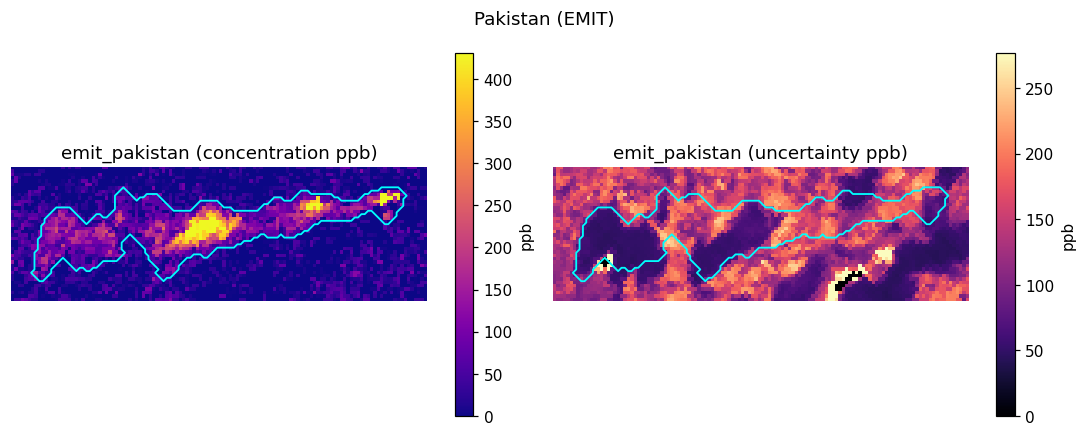

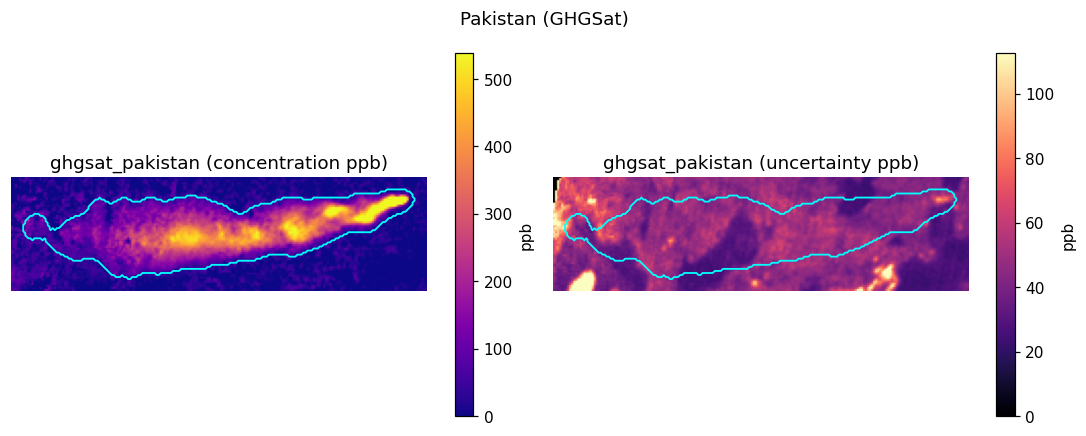

In [24]:
plot_segmented_overlays(all_results, reporter=reporter)

/tmp/ipykernel_8392/2939471859.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.02, 0.05, 0.82, 0.95])


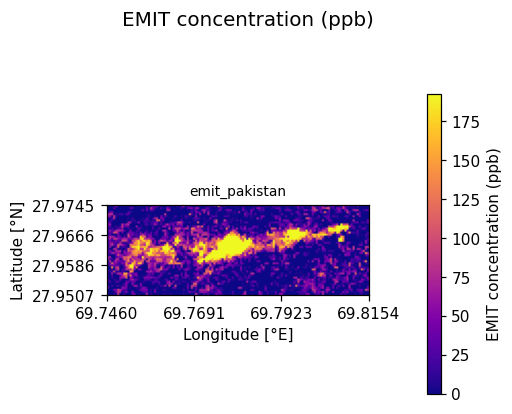

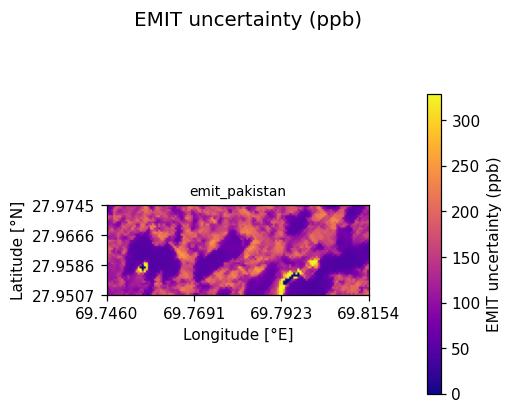

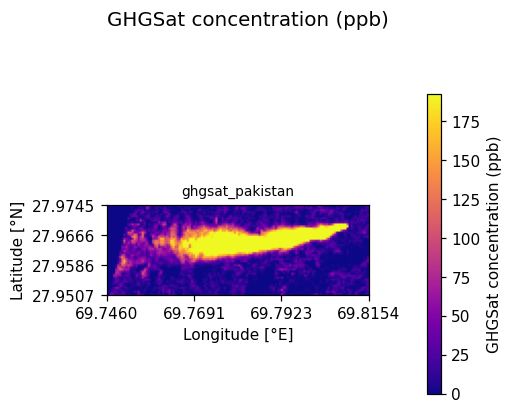

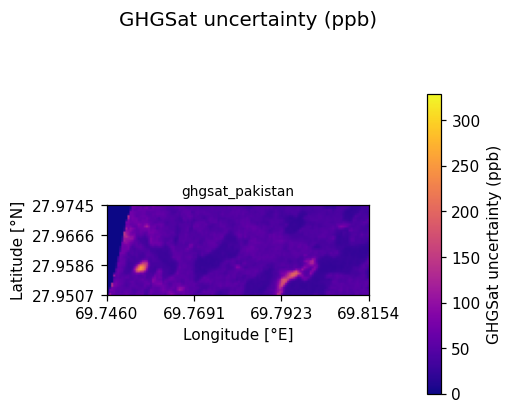

In [25]:
import matplotlib.ticker as mticker
import rasterio
from rasterio.transform import Affine, array_bounds
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS as RioCRS
from rasterio.windows import Window, transform as window_transform

def _to_affine(gt): return Affine.from_gdal(*gt)

# Reference grid: prefer EMIT, else first
REF_SENSOR = 'EMIT' if any(r['sensor'] == 'EMIT' for r in all_results) else all_results[0]['sensor']
ref_res = next(r for r in all_results if r['sensor'] == REF_SENSOR)
ref_h, ref_w = ref_res['concentration_ppb'].shape
ref_transform = _to_affine(ref_res['geotransform'])
ref_crs = RioCRS.from_wkt(ref_res['projection'])

def _window_extent(window):
    r0, r1, c0, c1 = window
    win = Window.from_slices((r0, r1), (c0, c1))
    win_transform = window_transform(win, ref_transform)
    west, south, east, north = array_bounds(int(win.height), int(win.width), win_transform)
    return (west, east, south, north)

def _reproject_array(arr, src_gt, src_proj, resampling):
    dst = np.full((ref_h, ref_w), np.nan, dtype=np.float32)
    reproject(
        source=np.where(np.isfinite(arr), arr, np.nan),
        destination=dst,
        src_transform=_to_affine(src_gt),
        src_crs=RioCRS.from_wkt(src_proj),
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=resampling,
        dst_nodata=np.nan,
    )
    return dst

def _reproject_mask(res):
    mask = res.get('plume_mask')
    if mask is None and res.get('vector_path') is not None:
        mask = _rasterize_vector(
            res['vector_path'],
            res['concentration_ppb'].shape[0],
            res['concentration_ppb'].shape[1],
            res['geotransform'],
            res['projection'],
        )
    if mask is None:
        return None
    dst = np.zeros((ref_h, ref_w), dtype=np.uint8)
    reproject(
        source=mask.astype(np.uint8),
        destination=dst,
        src_transform=_to_affine(res['geotransform']),
        src_crs=RioCRS.from_wkt(res['projection']),
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=Resampling.nearest,
        dst_nodata=0,
    )
    return dst.astype(bool)

def _set_lonlat_ticks(ax, extent):
    west, east, south, north = extent
    ax.set_xticks(np.linspace(west, east, 4))
    ax.set_yticks(np.linspace(south, north, 4))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
    ax.tick_params(direction='out', length=4, width=0.8, colors='black')
    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    ax.grid(False)

REPROJECTED = {}
for res in all_results:
    conc_src = res.get('concentration_ppb', res['concentration_raw'])
    unc_src = res.get('uncertainty_ppb', res['uncertainty_raw'])
    REPROJECTED[res['label']] = {
        'conc': _reproject_array(conc_src, res['geotransform'], res['projection'], Resampling.bilinear),
        'unc': _reproject_array(unc_src, res['geotransform'], res['projection'], Resampling.bilinear),
        'mask': _reproject_mask(res),
        'meta': res,
    }

def compute_plume_window(pad=8):
    mask_union = np.zeros((ref_h, ref_w), dtype=bool)
    for val in REPROJECTED.values():
        m = val.get('mask')
        if m is not None:
            mask_union |= m
    if not mask_union.any():
        return (0, ref_h, 0, ref_w), _window_extent((0, ref_h, 0, ref_w))
    rows, cols = np.where(mask_union)
    r0 = max(rows.min() - pad, 0); r1 = min(rows.max() + pad + 1, ref_h)
    c0 = max(cols.min() - pad, 0); c1 = min(cols.max() + pad + 1, ref_w)
    win = (r0, r1, c0, c1)
    return win, _window_extent(win)

PLOT_WINDOW, PLOT_EXTENT = compute_plume_window(pad=8)
POLY_COLOR = 'cyan'

def _global_vmax(key, pct=99):
    vals = []
    for r in REPROJECTED.values():
        finite = r[key][np.isfinite(r[key])]
        if finite.size:
            vals.append(np.nanpercentile(finite, pct))
    return float(np.nanmax(vals)) if vals else None

GLOBAL_VMAX_CONC = _global_vmax('conc', pct=99)
GLOBAL_VMAX_UNC  = _global_vmax('unc',  pct=98)

def mosaic_plot_common(results, key, title, cmap='plasma', vmin=0, vmax=None, cols=2):
    n = len(results); cols = min(cols, n); rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4.8 * cols, 4.2 * rows))
    axes = np.atleast_2d(axes)
    r0, r1, c0, c1 = PLOT_WINDOW
    im = None
    for ax, res in zip(axes.flat, results):
        arr = REPROJECTED[res['label']][key][r0:r1, c0:c1]
        im = ax.imshow(np.ma.masked_invalid(arr), cmap=cmap, vmin=vmin, vmax=vmax,
                       extent=PLOT_EXTENT, origin='upper')
        ax.set_title(res['label'], fontsize=9)
        _set_lonlat_ticks(ax, PLOT_EXTENT)
        ax.set_aspect('equal')
    for ax in list(axes.flat)[n:]: ax.axis('off')
    cax = fig.add_axes([0.84, 0.15, 0.025, 0.65])
    fig.colorbar(im, cax=cax, label=title)
    fig.suptitle(title, fontsize=13)
    fig.tight_layout(rect=[0.02, 0.05, 0.82, 0.95])
    return fig

emit_results = [r for r in all_results if r['sensor'] == 'EMIT']
if emit_results:
    mosaic_plot_common(emit_results, 'conc', 'EMIT concentration (ppb)',
                       vmin=0, vmax=GLOBAL_VMAX_CONC, cols=1); plt.show()
    mosaic_plot_common(emit_results, 'unc', 'EMIT uncertainty (ppb)',
                       vmin=0, vmax=GLOBAL_VMAX_UNC, cols=1); plt.show()

ghg_results = [r for r in all_results if r['sensor'] == 'GHGSAT']
if ghg_results:
    mosaic_plot_common(ghg_results, 'conc', 'GHGSat concentration (ppb)',
                       vmin=0, vmax=GLOBAL_VMAX_CONC, cols=1); plt.show()
    mosaic_plot_common(ghg_results, 'unc', 'GHGSat uncertainty (ppb)',
                       vmin=0, vmax=GLOBAL_VMAX_UNC, cols=1); plt.show()


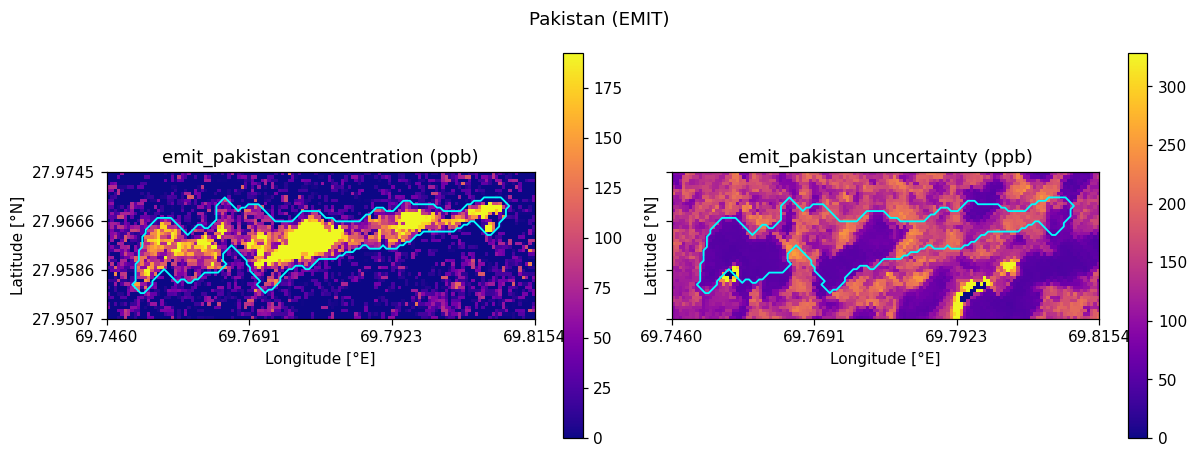

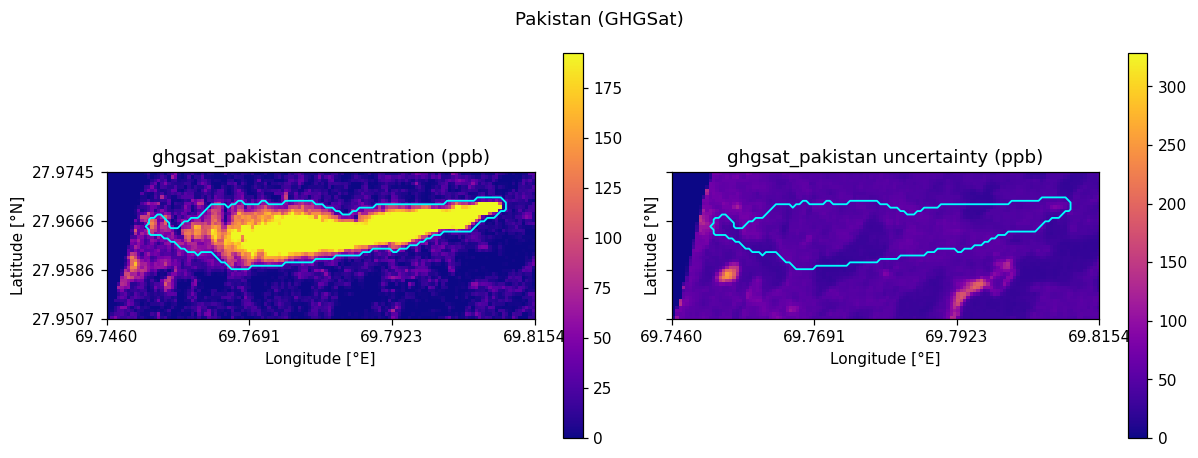

In [26]:
def plot_segmented_overlays_common(
    results,
    reporter=None,
    vmin_conc=0,
    vmin_unc=0,
    vmax_conc=GLOBAL_VMAX_CONC,
    vmax_unc=GLOBAL_VMAX_UNC,
    pct=99.0,
    poly_color=POLY_COLOR,
):
    r0, r1, c0, c1 = PLOT_WINDOW
    extent = PLOT_EXTENT
    west, east, south, north = extent

    def _auto_vmax_local(arr, pct=99.0):
        if arr.size == 0: return None
        vmax = float(np.nanpercentile(arr, pct))
        if not np.isfinite(vmax) or vmax <= 0:
            vmax = float(np.nanmax(arr)) if np.isfinite(np.nanmax(arr)) else None
        return vmax if vmax and vmax > 0 else None

    def _lonlat_ticks(ax):
        ax.set_xticks(np.linspace(west, east, 4))
        ax.set_yticks(np.linspace(south, north, 4))
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
        ax.tick_params(direction='out', length=4, width=0.8, colors='black')
        ax.set_xlabel('Longitude [°E]')
        ax.set_ylabel('Latitude [°N]')
        ax.grid(False)

    x_coords = np.linspace(west, east, c1 - c0)
    y_coords = np.linspace(north, south, r1 - r0)

    for res in results:
        data = REPROJECTED[res['label']]
        conc = data['conc'][r0:r1, c0:c1]
        unc = data['unc'][r0:r1, c0:c1]
        mask = data['mask']
        mask_crop = mask[r0:r1, c0:c1] if mask is not None else np.isfinite(conc)

        conc_vmax = vmax_conc if vmax_conc is not None else _auto_vmax_local(conc, pct=pct)
        unc_vmax  = vmax_unc  if vmax_unc  is not None else _auto_vmax_local(unc,  pct=pct)

        fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), sharex=True, sharey=True)

        im0 = axes[0].imshow(np.ma.masked_invalid(conc), cmap='plasma',
                             vmin=vmin_conc, vmax=conc_vmax,
                             extent=extent, origin='upper')
        axes[0].contour(x_coords, y_coords, mask_crop.astype(float),
                        levels=[0.5], colors=poly_color, linewidths=1.2)
        axes[0].set_title(f"{res['label']} concentration (ppb)")
        plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.06)

        im1 = axes[1].imshow(np.ma.masked_invalid(unc), cmap='plasma',
                             vmin=vmin_unc, vmax=unc_vmax,
                             extent=extent, origin='upper')
        axes[1].contour(x_coords, y_coords, mask_crop.astype(float),
                        levels=[0.5], colors=poly_color, linewidths=1.2)
        axes[1].set_title(f"{res['label']} uncertainty (ppb)")
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.06)

        for ax in axes:
            ax.set_aspect('equal')
            _lonlat_ticks(ax)

        fig.suptitle(res['scene'], fontsize=12)
        fig.tight_layout()
        if reporter is not None:
            reporter.log_figure(f"{res['label']}_plume_overlay_geo", fig)
        plt.show()

plot_segmented_overlays_common(
    all_results,
    reporter=reporter,
    vmin_conc=0,
    vmin_unc=0,
    vmax_conc=GLOBAL_VMAX_CONC,
    vmax_unc=GLOBAL_VMAX_UNC,
    pct=99.0,
    poly_color=POLY_COLOR,
)
